In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

from cleaning import df
sns.set()

Based on my EDA, there are some columns I am going to drop from my dataset due to strong multicollinearity and statistics that inform the other. I will be dropping `pts` which is a combination of `twop`, `threep`, and `ft`. Additionally, this will help me see if there are meaningful differences in how different scoring methods affect a player's likelihood to be an allstar. I am dropping `trb` because it is the combined total of `drb` and `orb`. I will also be dropping `fgp`, `twopp`, `threepp`, and `ftp` because they are calculated from using makes divided by attempts.

In [2]:
#df = df.drop(columns=['pts', 'trb', 'fgp', 'twopp', 'threepp', 'ftp'])

I want to set up a pipeline that performs GridSearchCV on every step from Feature Selection, Hyperparameter Tuning, and Learning Model Selection.

Feature Selection:
- `VarianceThreshold`
- `SelectKBest`
- `SelectFromModel`

Hyperparameter Tuning:
- `GridSearchCV`

Learning Model Selection:
- `LogisticRegression`
- `RandomForestClassifier`
- `SVM`
- `KNNeighborsClassifier`


Metrics:
- ROC-AUC
- F1 Score



# Feature Selection
There are 3 different methods of feature selection that I will consider: `VarianceThreshold`, `SelectKBest`, and `SelectFromModel`.

`VarianceThreshold` removes all features with a variance equal to 0. Since I do not have any columns with the same values throughout, this will not help me reduce the dimensionality of my dataset.

`SelectKBest` selects a defined number of categories, k, that are most descriptive of the data. For classification problems, there are 3 types of tests that can be run to score the features: `chi2`, `f_classif`, and `mutual_info_classif`. `chi2` uses a $\chi^{2}$ test to measure dependence between stochastic varables, so this function removes features that are most likely to be independent of class and therefore irrelevant to classification. However, it requires all positive values, and when I scale my data, some values are below 0.  `f_classif` calculates the ANOVA F-value for the sample which is the ratio of two features' variance. `mutual_info_classif` estimates mutual information for a discrete target variable. If MI between two random variables is 0, they are independent, and a high MI means higher dependency.

For my purposes, I will use `SelectKBest` and use `mutual_info_classif` to determine the best features.

To begin, I set `int_df` equal to the numeric columns of my dataset. I then split it into the feature columns and the target column, `allstar_next`. I then separate each of these new dataframes into training datasets and test datasets. I use StandardizedScaler to preprocess the feature dataset. The target data is binary so no standardization is necesary.

In order to prevent leakage in my model, I fit it to the training set ONLY, and then use this fitted model to transform both the training and test sets.

In [3]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)


skb = SelectKBest(mutual_info_classif, k=features.shape[1])
skb.fit(Xtrain, ytrain)
mask = skb.get_support()
kbestfeat = list()

for boolean, feature in zip(mask, int_df.columns):
    if boolean:
        kbestfeat.append(feature)

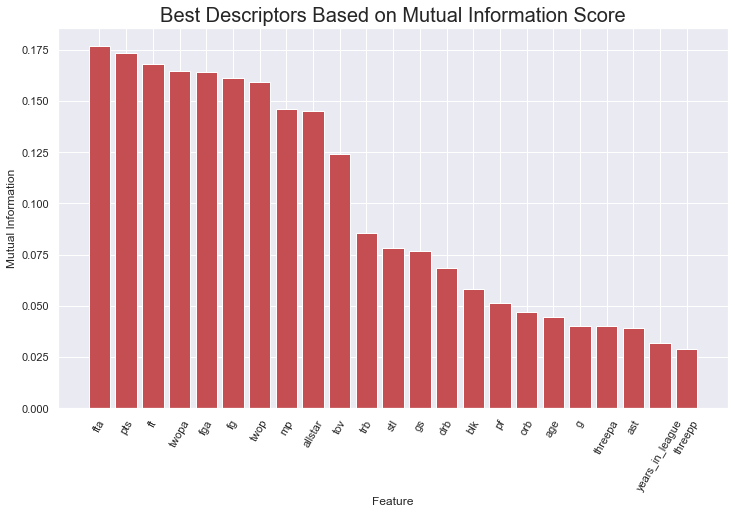

In [4]:
indices = np.argsort(skb.scores_)[::-1]
cols = []
for i in range(23):
    cols.append(int_df.columns[indices[i]])

# Now plot
plt.figure(figsize=[12,7])
plt.bar(cols, skb.scores_[indices[range(23)]], color='r', align='center')
plt.xticks(rotation=60)
plt.title('Best Descriptors Based on Mutual Information Score', size=20)
plt.xlabel('Feature')
plt.ylabel('Mutual Information')
plt.show()

My 10 most descriptive features are: `fta`, `ft`, `twop`, `fg`, `twopa`, `allstar`, `fga`, `mp`, `tov`, and `gs`. However, I don't know if feature selection is even the best option for me. In order to check this, I will run some tests on the ability of my model to correctly predict my data using different number of features

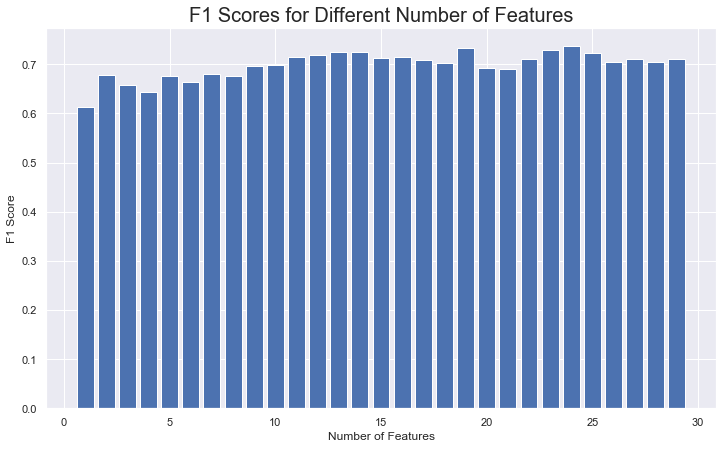

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
lr = LogisticRegression(max_iter=10000, solver='lbfgs')
pipeline = make_pipeline(scaler, lr)

f1s = []
for i in range(1, len(kbestfeat)+1):
    
    features = int_df[cols[:i]].values
    target = int_df.loc[:, 'allstar_next'].values

    Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
    
    pipeline.fit(Xtrain, ytrain)
    ypred = pipeline.predict(Xtest)
    
    f1s.append(f1_score(ytest, ypred))
    
plt.figure(figsize=(12,7))
plt.bar(x=range(1, len(kbestfeat)+1), height=f1s);
plt.title('F1 Scores for Different Number of Features', size=20);
plt.xlabel('Number of Features');
plt.ylabel('F1 Score');

Since there is an initial increase in prediction power and then very small increases with more features, I am not going to reduce the dimensionality of my dataset further than I already have. Increased information will hopefully help me tune my model more effectively.

# Logistic Regression
There are a variety of parameters for logistic regression, but many of them do not apply to my question for a variety of reasons or I have made a selection based on the scikit-learn documentation. For instance, while there are many potential solvers many do not make sense for my project. `sag` and `saga` are for very large datasets. Given that I do not have an excess of columns, I want to use L2 penalty rather than L1 which could induce too much sparsity. Using `newton-cg` comes with many problems such as being computationally expensive and being attracted to Saddle Points where it can become confused about whether the input is a maximum or minimum. This leaves me with `liblinear` and `lbfgs`. I will use `lbfgs` because it is the default setting for `LogisticRegression` and will serve my purposes well.

I have determined the following parameters to be most important for my model construction:
- `C`
- `fit_intercept`

I chose to use GridSearchCV over RandomizedSearchCV because the range of parameters and the size of my dataset is not so large as to cause problems. My scoring metric to determine the best model will be the F1 score because in my dataset, there are more seasons where the next year a player is not an allstar than there are seasons where a player is. Looking at accuracy alone would artificially inflate the models success rate.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df[kbestfeat[:10]].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

lr = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=13)
parameters = {'C':[0.001, 0.1, 1, 10, 10e8],
              'fit_intercept': [True, False]
             }
gscv = GridSearchCV(lr, parameters, cv=5, 
                          scoring = 'f1',
                          error_score=np.nan)


In [7]:
gscv.fit(Xtrain, ytrain)
print('Parameters:\n{}\nF1 Score:{}'.format(gscv.best_params_, 
                                            gscv.best_score_))
C = gscv.best_params_['C']
fit_intercept = gscv.best_params_['fit_intercept']

Parameters:
{'C': 1000000000.0, 'fit_intercept': False}
F1 Score:0.7023670586821215


Based off of the grid search results, my parameters for the model should be:
- `C`: 10e8
- `fit_intercept`: False

I now want to test my model's effectiveness at predicting new data. Below I set up a pipeline to standardize the data and then perform logistic regression on the test samples. I will then produce a confusion matrix, classification report, and ROC curve.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next'].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
scaler = StandardScaler()

lr = LogisticRegression(C=C, fit_intercept=fit_intercept,
                       max_iter=10000, solver='lbfgs')

pipeline = make_pipeline(scaler, lr)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


[[467 140]
 [ 66 292]]
              precision    recall  f1-score   support

         0.0       0.88      0.77      0.82       607
         1.0       0.68      0.82      0.74       358

    accuracy                           0.79       965
   macro avg       0.78      0.79      0.78       965
weighted avg       0.80      0.79      0.79       965



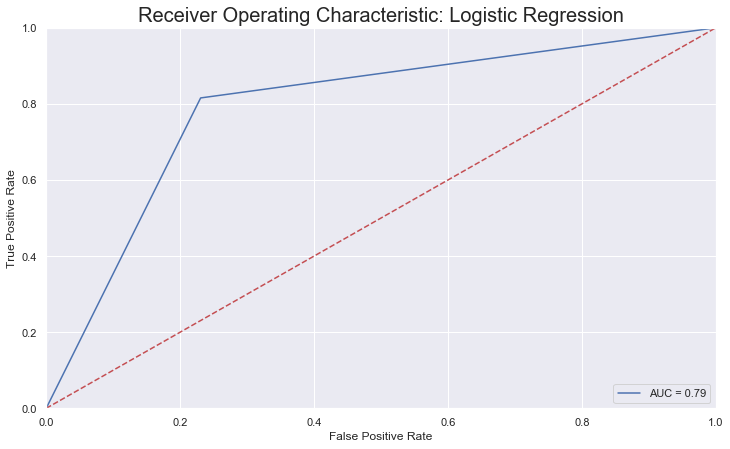

In [9]:
from sklearn.metrics import roc_curve, auc

fprlr, tprlr, threshold = roc_curve(ytest, ypred)
roc_auclr = auc(fprlr, tprlr)

plt.figure(figsize=(12,7));
plt.title('Receiver Operating Characteristic: Logistic Regression', size=20);
plt.plot(fprlr, tprlr, 'b', label = 'AUC = %0.2f' % roc_auclr);
plt.legend(loc = 'lower right');
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.ylabel('True Positive Rate');
plt.xlabel('False Positive Rate');
plt.show();

# Random Forest Classifier
I now want to explore using a Random Forest Classifier on my data. `RandomForestClassifer` has even more parameters than `LogisticRegression`, so I will use `RandomizedSearchCV` for this testing. After looking through the documentation, I believe the following parameters are most important to do grid search on:

`n_estimators` represents the number of trees in the forest. With more trees, the model better learns the data, but having too many leads to overfitting and slows down the training process considerably.

`max_depth` is how many splits each tree will have. If it is too high, then the model overfits to the training data.

`max_features` represents the number of features to consider when looking for the best split. At high values, it leads to overfitting.

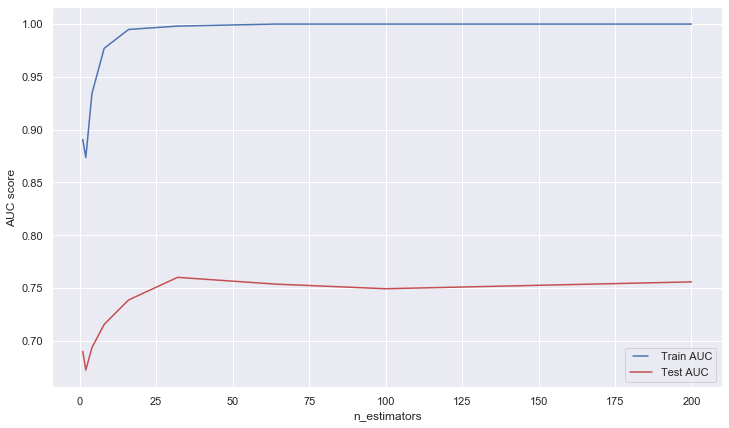

In [10]:
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(features, target)

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(12,7))
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

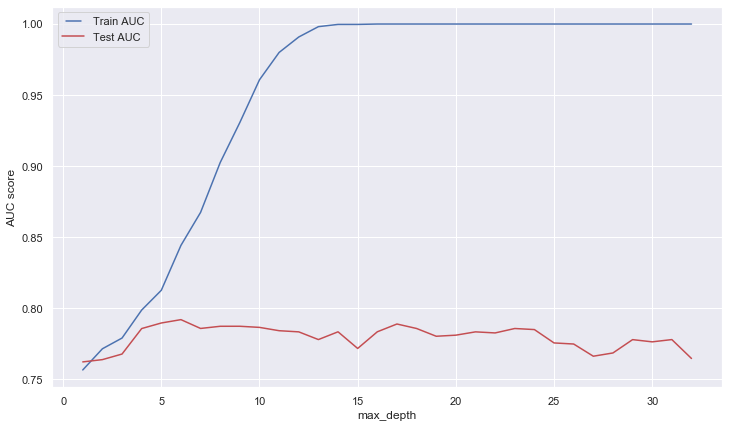

In [11]:
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(features, target)

max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, n_estimators=100)
    rf.fit(x_train, y_train)
    train_pred = rf.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D

plt.figure(figsize=(12,7))
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_depth')
plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next'].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)

scaler = StandardScaler()
rfc = RandomForestClassifier(bootstrap=True)

param_grid = {
    'n_estimators': [2, 4, 8, 16, 32],
    'max_depth': [2, 5, 10],
    'max_features': list(range(1, features.shape[1]))
}

rscv = RandomizedSearchCV(rfc, n_iter=15, param_distributions=param_grid, 
                          cv=5, scoring = 'f1',
                          error_score=np.nan)

In [13]:
rscv.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None,
              

In [14]:
print(rscv.best_params_, rscv.best_score_)

{'n_estimators': 16, 'max_features': 21, 'max_depth': 5} 0.7270931833439602


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)

scaler = StandardScaler()
rfc = RandomForestClassifier(n_estimators=16, max_features=21,
                            max_depth=5)
pipeline = make_pipeline(scaler, rfc)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


[[521  87]
 [ 93 264]]
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       608
         1.0       0.75      0.74      0.75       357

    accuracy                           0.81       965
   macro avg       0.80      0.80      0.80       965
weighted avg       0.81      0.81      0.81       965



In [16]:
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending=False)
feature_imp

allstar            0.350354
fta                0.126045
twopa              0.122691
pts                0.071488
twop               0.048932
fg                 0.043346
mp                 0.038768
years_in_league    0.031721
age                0.018860
trb                0.018426
ft                 0.017052
ast                0.010699
efgp               0.009550
stl                0.009131
blk                0.008984
fga                0.008593
pf                 0.008428
drb                0.007801
fgp                0.006469
ftp                0.005974
orb                0.005687
threepp            0.005337
gs                 0.004524
tov                0.004361
twopp              0.004179
threep             0.004093
height             0.003999
g                  0.003589
threepa            0.000918
dtype: float64

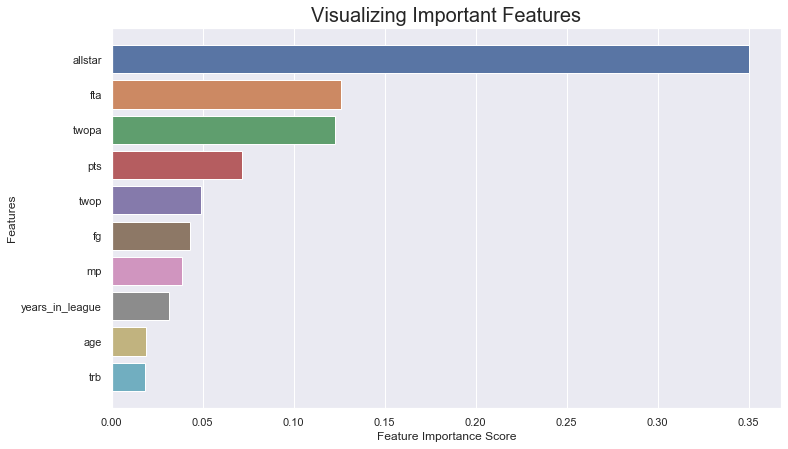

In [17]:
plt.figure(figsize=(12,7))
sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index);
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');
plt.title('Visualizing Important Features', size=20);
plt.plot();

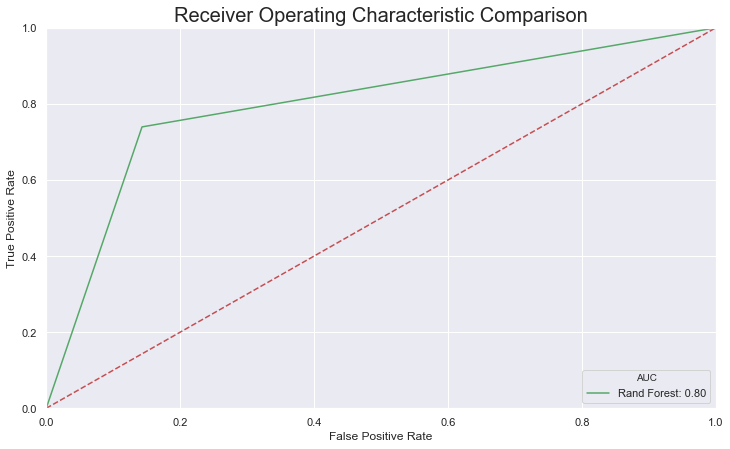

In [18]:
from sklearn.metrics import roc_curve, auc

fprrfc, tprrfc, threshold = roc_curve(ytest, ypred)
roc_aucrfc = auc(fprrfc, tprrfc)

plt.figure(figsize=(12,7))
plt.title('Receiver Operating Characteristic Comparison', size=20)
plt.plot(fprrfc, tprrfc, 'g', label='Rand Forest: %0.2f' % roc_aucrfc)
plt.legend(title='AUC', loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Based on this testing, Random Forest Classifier is worse than a Logistic Regression. I will now test Support Machine Vectors

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from tempfile import mkdtemp

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

svc = SVC(gamma='scale')

param_grid = {
    'C' : [0.001, 1, 1000000],
    'kernel' : ['poly', 'rbf', 'sigmoid'],
    'degree' : [2, 3]
}

gscv = GridSearchCV(svc, param_grid, cv=5,
                    scoring = 'f1',
                    error_score=np.nan)

In [ ]:
gscv.fit(Xtrain, ytrain)

In [ ]:
print(gscv.best_params_, gscv.best_score_)

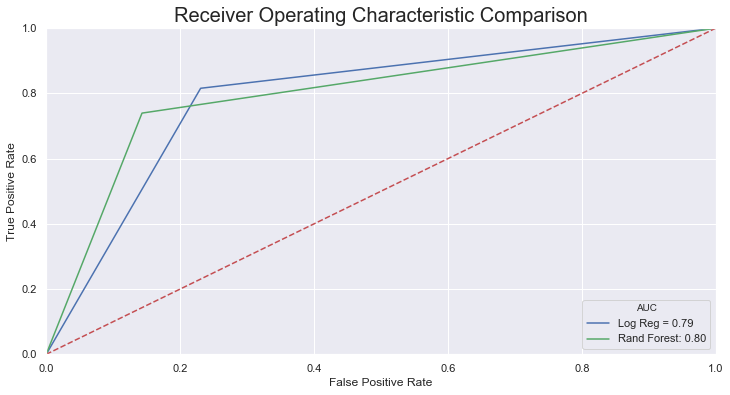

In [19]:
from sklearn.metrics import roc_curve, auc

fprrfc, tprrfc, threshold = roc_curve(ytest, ypred)
roc_aucrfc = auc(fprrfc, tprrfc)

plt.figure(figsize=(12,6))
plt.title('Receiver Operating Characteristic Comparison', size=20)
plt.plot(fprlr, tprlr, 'b', label = 'Log Reg = %0.2f' % roc_auclr)
plt.plot(fprrfc, tprrfc, 'g', label='Rand Forest: %0.2f' % roc_aucrfc)
#plt.plot(fprsvm, tprsvm, 'p', label='SVM: %0.2f' % roc_aucsvm)
plt.legend(title='AUC', loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Use this link to make a comparative model optimization cell
https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html

I found this code at [http://www.davidsbatista.net/blog/2018/02/23/model_optimization/] which allows me to test multiple models and parameters at once.


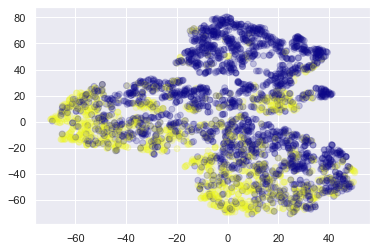

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next'].values
target = int_df.loc[:, 'allstar_next'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target)
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

model = TSNE(learning_rate=100)
transformed = model.fit_transform(int_df)
xs = transformed[:, 0]
ys = transformed[:, 1]
_ = plt.scatter(xs, ys, c=target, cmap='plasma', alpha = 0.2)
_ = plt.show()